### Test case LVV-T33: Verify implementation of Raw Science Image Metadata

Verify successful ingestion of raw data and that image metadata is present and queryable.

**Specification:** For each raw science image, the DMS shall store image metadata including at least:

* Time of exposure start and end, referenced to TAI, and DUT1
* Site metadata (site seeing, transparency, weather, observatory location)
* Telescope metadata (telescope pointing, active optics state, environmental state)
* Camera metadata (shutter trajectory, wavefront sensors, environmental state)
* Program metadata (identifier for main survey, deep drilling, etc.)
* Scheduler metadata (visitID, intended number of exposures in the visit)

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
from astropy.table import Table

Initialize the butler, and define the collection (corresponding to w_2025_33 processing) we will use.

In [2]:
COLLECTION = "LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202"
butler = Butler("/repo/embargo")

Query the butler for `raw` images, then select a single dataId and retrieve an image and its associated metadata.

In [3]:
query = butler.query_datasets('raw', collections=COLLECTION, with_dimension_records=True)

In [4]:
query[0]

DatasetRef(DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 52, exposure: 2025070400488, band: 'z', day_obs: 20250704, group: '2025-07-05T05:15:40.802', physical_filter: 'z_20'}, run='LSSTCam/raw/all', id=6fbfc9a8-dae8-5f96-bdf2-77ad21262a54)

In [5]:
data_id = query[0].dataId

In [6]:
# Select the first image:
raw_img = butler.get(query[0])

In [7]:
# Check for a WCS, photocalib, image statistics, etc.
print('\nWhat type of object is it?')
print('--------------------------')
print(raw_img)

print('\nPixel data type:')
print('-----------------')
print(raw_img.dtype)

print('\nVisit info:')
print('------------')
print(raw_img.visitInfo)

print('\nImage shape and statistics:')
print('----------------------------')
print('Shape: ', np.shape(raw_img.image.array))
print('Mean, median, std deviation of pixel values: ', np.nanmean(raw_img.image.array),
      np.nanmedian(raw_img.image.array), np.nanstd(raw_img.image.array))

print('\nMetadata:')
print('----------')
md = raw_img.getMetadata()
md_dict = md.toDict()

for item in md_dict.items():
    print(item)


What type of object is it?
--------------------------

Pixel data type:
-----------------
<class 'numpy.float32'>

Visit info:
------------
VisitInfo(exposureTime=30.0001, darkTime=30.9295, date=2025-07-05T05:18:46.427061339, UT1=nan, ERA=0.0466829 rad, boresightRaDec=(318.4070448063, -14.4605073897), boresightAzAlt=(62.8679456533, +60.8718332734), boresightAirmass=1.14444, boresightRotAngle=1.36126 rad, rotType=1, observatory=-30.2446N, -70.7494E  2663, weather=Weather(11.7, 74405, 11.975), instrumentLabel='LSSTCam', id=2025070400488, focusZ=-3.20247, observationType='science', scienceProgram='BLOCK-365', observationReason='pairs_zy_33.0', object='lowdust', hasSimulatedContent=false)

Image shape and statistics:
----------------------------
Shape:  (4096, 4608)
Mean, median, std deviation of pixel values:  28572.84 28539.0 5323.15

Metadata:
----------
('SIMPLE', True)
('EXTEND', True)
('BINX', 1)
('BINY', 1)
('CCDGAIN', 1.0)
('CCDNOISE', 10.0)
('DETSIZE', '[1:4096,1:4004]')
('DATE',

We see that much of the required information is contained in the header/metadata associated with the `raw` image. For example, the time of exposure start and end is given as "DATE-BEG" and "DATE-END", with "TIMESYS=TAI". Metadata entries for site conditions include "SEEING", "AIRTEMP", "PRESSURE", "HUMIDITY", "WINDSPD", and "WINDDIR", and the observatory location is specified via "TELESCOP", "OBS-LONG", "OBS-LAT", "OBS-ELEV", "OBSGEO-X", "OBSGEO-Y", and "OBSGEO-Z".

Additional metadata seen above details the telescope pointing, sensor readings, and camera metadata and telemetry.

### Program and scheduler metadata:

Program and scheduler metadata can be seen in the following cell. This includes information such as the "observation_reason", "target_name", and the "science_program". The "seq_num", "seq_start", and "seq_end" values are all identical in this case, because the scheduler requested only a single exposure.

In [8]:
query[0].dataId.exposure

exposure.RecordClass(instrument='LSSTCam', id=2025070400488, day_obs=20250704, group='2025-07-05T05:15:40.802', physical_filter='z_20', obs_id='MC_O_20250704_000488', exposure_time=30.0, dark_time=30.9295, observation_type='science', observation_reason='pairs_zy_33.0', seq_num=488, seq_start=488, seq_end=488, target_name='lowdust', science_program='BLOCK-365', tracking_ra=318.40704480633815, tracking_dec=-14.460507389707633, sky_angle=77.99440026788089, azimuth=62.8679456532809, zenith_angle=29.1281667265786, has_simulated=False, can_see_sky=True, timespan=Timespan(begin=astropy.time.Time(2460862.0, -0.27880830876528934, scale='tai', format='jd'), end=astropy.time.Time(2460862.0, -0.2784503240740741, scale='tai', format='jd')))

### Retrieve the raw guider images:

Guider images associated with an exposure can be retrieved as `Stamps` datasets. For example, detector 194 is a guide detector -- to retrieve its images for the same exposure we retrieved above, do the following:

In [9]:
guider_raw = butler.get('guider_raw', exposure=data_id['exposure'], instrument='LSSTCam', detector=194, collections='LSSTCam/raw/guider')

In [10]:
guider_raw

In [11]:
# Retrieve all of the images from the guider corresponding to this exposure:
guider_raw_imgs = guider_raw.getMaskedImages()

In [12]:
np.shape(guider_raw_imgs)

(50,)

We see that there are 50 guider stamps in the dataset.

Display one:

In [13]:
afwDisplay.setDefaultBackend('matplotlib')

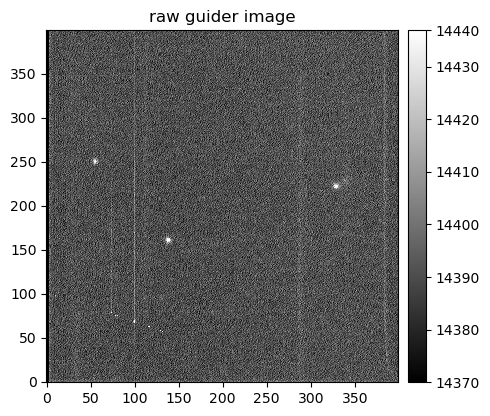

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
display0.mtv(guider_raw_imgs[10].image)
plt.title('raw guider image')

plt.tight_layout()
plt.show()

### Wavefront sensor images

Wavefront sensor images are archived in multiple locations, but are currently not ingested into the Butler. Below we demonstrate retrieving and viewing one wavefront sensor image corresponding to the `raw` exposure we have been exploring.

In [15]:
data_id

{instrument: 'LSSTCam', detector: 52, exposure: 2025070400488, band: 'z', day_obs: 20250704, group: '2025-07-05T05:15:40.802', physical_filter: 'z_20'}

In [16]:
# Path at USDF where the ancillary data are archived as ZIP files:
path = '/sdf/data/rubin/lsstdata/offline/instrument/LSSTCam/20250704'

In [17]:
import zipfile

In [18]:
# Open a zip file and examine the contents:
zfile = zipfile.ZipFile(path+'/MC_O_20250704_000488.zip')

In [19]:
zfile.infolist()

[<ZipInfo filename='MC_O_20250704_000488_R40_SW1.fits' filemode='-rw-r-----' file_size=10215360>,
 <ZipInfo filename='MC_O_20250704_000488_R11_S00.fits' filemode='-rw-r-----' file_size=19422720>,
 <ZipInfo filename='MC_O_20250704_000488_R10_S20.fits' filemode='-rw-r-----' file_size=19111680>,
 <ZipInfo filename='MC_O_20250704_000488_R10_S11.fits' filemode='-rw-r-----' file_size=19235520>,
 <ZipInfo filename='MC_O_20250704_000488_R11_S10.fits' filemode='-rw-r-----' file_size=19615680>,
 <ZipInfo filename='MC_O_20250704_000488_R11_S02.fits' filemode='-rw-r-----' file_size=19569600>,
 <ZipInfo filename='MC_O_20250704_000488_R10_S22.fits' filemode='-rw-r-----' file_size=19301760>,
 <ZipInfo filename='MC_O_20250704_000488_R02_S00.fits' filemode='-rw-r-----' file_size=19278720>,
 <ZipInfo filename='_metadata_index.json' compress_type=deflate filemode='-rw-r-----' file_size=286771 compress_size=21746>,
 <ZipInfo filename='MC_O_20250704_000488_R01_S21.fits' filemode='-rw-r-----' file_size=1941

The wavefront sensors have "SW" in their names. Extract one of those images from the zip archive and display it:

In [20]:
zfile.extract('MC_O_20250704_000488_R40_SW1.fits')

'/sdf/data/rubin/user/jcarlin/SVV/test_campaigns/ccr1_2024_ATC/MC_O_20250704_000488_R40_SW1.fits'

In [21]:
from astropy.io import fits

In [22]:
wfs_img = fits.getdata('/sdf/data/rubin/user/jcarlin/SVV/test_campaigns/ccr1_2024_ATC/MC_O_20250704_000488_R40_SW1.fits')

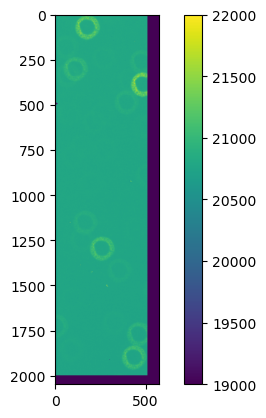

In [23]:
plt.imshow(wfs_img, vmin=19000, vmax=22000)
plt.colorbar()
plt.show()

### Shutter motion profiles

Shutter motion profiles are part of the zip archives that also contain wavefront sensor and guider data. Recently, the ingestion of shutter motion profiles into the Butler has been developed. We will retrieve and examine one of these from a test repository.

In [24]:
butler = Butler("/scratch/users/c/czw/asdf")
smpO = butler.get("shutterMotionProfileOpen", instrument="LSSTCam", 
                  exposure=2025051400319, collections="LSSTCam/calib/shutterMotion")
smpC = butler.get("shutterMotionProfileClose", instrument="LSSTCam", 
                  exposure=2025051400319, collections="LSSTCam/calib/shutterMotion")

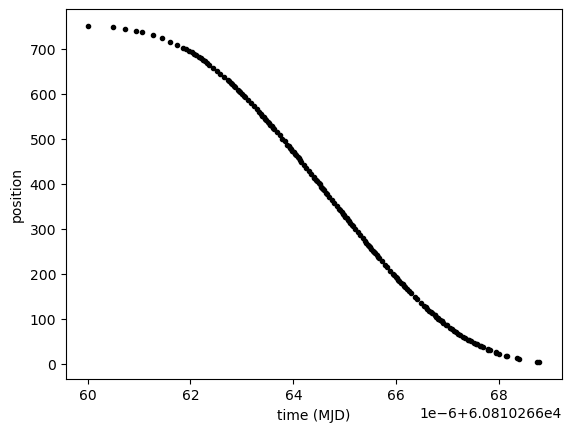

In [25]:
# Plot the profile with time:

plt.plot(smpO.time_mjd, smpO.position, 'k.')
plt.xlabel('time (MJD)')
plt.ylabel('position')
plt.show()

In [26]:
# Demonstration of a method to extract the midpoint time:
smpO.calculateMidpoint()

(np.float64(0.4502412626129274), np.float64(0.449691159967092))

## Results

We have demonstrated that the required metadata is available, as well as additional information. We deem this test's result a *Pass*.